# **Stable Diffusion** 🎨
*...using `🧨diffusers`*

Stable Diffusion is a text-to-image latent diffusion model created by the researchers and engineers from [CompVis](https://github.com/CompVis), [Stability AI](https://stability.ai/) and [LAION](https://laion.ai/). It's trained on 512x512 images from a subset of the [LAION-5B](https://laion.ai/blog/laion-5b/) database. This model uses a frozen CLIP ViT-L/14 text encoder to condition the model on text prompts. With its 860M UNet and 123M text encoder, the model is relatively lightweight and can run on many consumer GPUs.
See the [model card](https://huggingface.co/CompVis/stable-diffusion) for more information.

This Colab notebook shows how to use Stable Diffusion with the 🤗 Hugging Face [🧨 Diffusers library](https://github.com/huggingface/diffusers).

Let's get started!

## 1. How to use `StableDiffusionPipeline`

Before diving into the theoretical aspects of how Stable Diffusion functions,
let's try it out a bit 🤗.

In this section, we show how you can run text to image inference in just a few lines of code!

### Setup

First, please make sure you are using a GPU runtime to run this notebook, so inference is much faster. If the following command fails, use the `Runtime` menu above and select `Change runtime type`.

In [3]:
import torch

In [4]:
if torch.cuda.is_available():
    # Shows the nVidia GPUs, if this system has any
    !nvidia-smi

Wed Jan 15 01:42:59 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Next, you should install `diffusers` as well `scipy`, `ftfy` and `transformers`. `accelerate` is used to achieve much faster loading.

In [5]:
!pip install diffusers==0.11.1
!pip install transformers scipy ftfy accelerate

### Stable Diffusion Pipeline

`StableDiffusionPipeline` is an end-to-end inference pipeline that you can use to generate images from text with just a few lines of code.

First, we load the pre-trained weights of all components of the model. In this notebook we use Stable Diffusion version 1.4 ([CompVis/stable-diffusion-v1-4](https://huggingface.co/CompVis/stable-diffusion-v1-4)), but there are other variants that you may want to try:
* [runwayml/stable-diffusion-v1-5](https://huggingface.co/runwayml/stable-diffusion-v1-5)
* [stabilityai/stable-diffusion-2-1-base](https://huggingface.co/stabilityai/stable-diffusion-2-1-base)
* [stabilityai/stable-diffusion-2-1](https://huggingface.co/stabilityai/stable-diffusion-2-1). This version can produce images with a resolution of 768x768, while the others work at 512x512.

In addition to the model id [CompVis/stable-diffusion-v1-4](https://huggingface.co/CompVis/stable-diffusion-v1-4), we're also passing a specific `revision` and `torch_dtype` to the `from_pretrained` method.

We want to ensure that every free Google Colab can run Stable Diffusion, hence we're loading the weights from the half-precision branch [`fp16`](https://huggingface.co/CompVis/stable-diffusion-v1-4/tree/fp16) and also tell `diffusers` to expect the weights in float16 precision by passing `torch_dtype=torch.float16`.

If you want to ensure the highest possible precision, please make sure to remove `torch_dtype=torch.float16` at the cost of a higher memory usage.

In [6]:
# This is added to get around some issues of Torch not loading models correctly (test on Mac OS X and Kubuntu Linux)
!pip install --upgrade huggingface-hub==0.26.2 transformers==4.46.1 tokenizers==0.20.1 diffusers==0.31.0

  Using cached huggingface_hub-0.26.2-py3-none-any.whl.metadata (13 kB)
  Using cached transformers-4.46.1-py3-none-any.whl.metadata (44 kB)
  Using cached tokenizers-0.20.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Using cached diffusers-0.31.0-py3-none-any.whl.metadata (18 kB)
Using cached huggingface_hub-0.26.2-py3-none-any.whl (447 kB)
Using cached transformers-4.46.1-py3-none-any.whl (10.0 MB)
Using cached tokenizers-0.20.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.0 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 69.6 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.27.0
    Uninstalling huggingface-hub-0.27.0:
      Successfully uninstalled huggingface-hub-0.27.0
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.0
    Uninstalling tokenizers-0.21.0:
      Successfully uninstalled tokenizers-0.21.0
  Attempting uninstall:

In [41]:
# from diffusers import StableDiffusionPipeline

# pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16)

# 加载预训练的 Stable Diffusion 模型（Img2Img）
from diffusers import StableDiffusionImg2ImgPipeline
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Next, let's move the pipeline to GPU to have faster inference.

In [53]:
if torch.cuda.is_available():
    device=torch.device("cuda")
elif torch.backends.mps.is_available():
    device=torch.device("mps")

pipe = pipe.to(device)

And we are ready to generate images:

In [43]:
# 上传本地图片
from google.colab import files

print("请上传你自己的图片：")
uploaded = files.upload()
image_path = list(uploaded.keys())[0]  # 获取上传的图片文件路径

# 加载并预处理输入图片
init_image = Image.open(image_path).convert("RGB")
init_image = init_image.resize((512, 512))  # 将图片调整为 512x512（模型要求输入固定大小）



请上传你自己的图片：


IndexError: list index out of range

  0%|          | 0/40 [00:00<?, ?it/s]

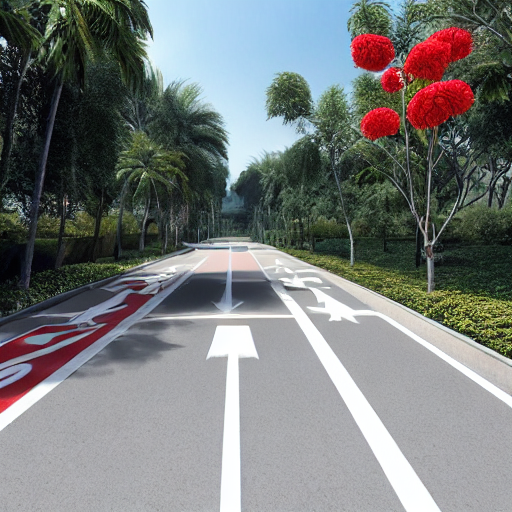

In [56]:
# 定义 prompt（生成图片的描述）

# 定义更新后的 prompt
prompt = (
"A realistic image of a dual four-lane highway with clear white lane markings. On both sides, spherical red Ixora bushes (红花继木球) with bright red flowers are planted. Keep the road and lane markings intact, only modify the greenery along the sides to red Ixora bushes."

)
# 调节 strength 参数控制生成效果
strength = 0.8 # 范围 0-1，值越小保留原始图片细节越多

# 使用上传的图片生成新图像
generated_image = pipe(prompt=prompt, image=init_image, strength=strength).images[0]

# 保存生成的图片
generated_image.save("generated_image_from_input.png")


generated_image

In [ ]:
# 展示生成图片
# 可选择直接下载图片到本地
files.download("generated_image_from_input.png")


Running the above cell multiple times will give you a different image every time. If you want deterministic output you can pass a random seed to the pipeline. Every time you use the same seed you'll have the same image result.

## 3. How to write your own inference pipeline with `diffusers`

Finally, we show how you can create custom diffusion pipelines with `diffusers`.
This is often very useful to dig a bit deeper into certain functionalities of the system and to potentially switch out certain components.

In this section, we will demonstrate how to use Stable Diffusion with a different scheduler, namely [Katherine Crowson's](https://github.com/crowsonkb) K-LMS scheduler that was added in [this PR](https://github.com/huggingface/diffusers/pull/185#pullrequestreview-1074247365).

Let's go through the `StableDiffusionPipeline` step by step to see how we could have written it ourselves.

We will start by loading the individual models involved.

The [pre-trained model](https://huggingface.co/CompVis/stable-diffusion-v1-3-diffusers/tree/main) includes all the components required to setup a complete diffusion pipeline. They are stored in the following folders:
- `text_encoder`: Stable Diffusion uses CLIP, but other diffusion models may use other encoders such as `BERT`.
- `tokenizer`. It must match the one used by the `text_encoder` model.
- `scheduler`: The scheduling algorithm used to progressively add noise to the image during training.
- `unet`: The model used to generate the latent representation of the input.
- `vae`: Autoencoder module that we'll use to decode latent representations into real images.

We can load the components by referring to the folder they were saved, using the `subfolder` argument to `from_pretrained`.

In [16]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

# 1. Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# 2. Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Now instead of loading the pre-defined scheduler, we'll use the K-LMS scheduler instead.

In [17]:
from diffusers import LMSDiscreteScheduler

scheduler = LMSDiscreteScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

Next we move the models to the GPU.

In [18]:
vae = vae.to(device)
text_encoder = text_encoder.to(device)
unet = unet.to(device)

We now define the parameters we'll use to generate images.

Note that `guidance_scale` is defined analog to the guidance weight `w` of equation (2) in the [Imagen paper](https://arxiv.org/pdf/2205.11487.pdf). `guidance_scale == 1` corresponds to doing no classifier-free guidance. Here we set it to 7.5 as also done previously.

In contrast to the previous examples, we set `num_inference_steps` to 100 to get an even more defined image.

In [19]:
prompt = ["a photograph of an astronaut riding a horse"]

height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion

num_inference_steps = 100            # Number of denoising steps

guidance_scale = 7.5                # Scale for classifier-free guidance

generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise

batch_size = 1

First, we get the text_embeddings for the prompt. These embeddings will be used to condition the UNet model.

In [20]:
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

We'll also get the unconditional text embeddings for classifier-free guidance, which are just the embeddings for the padding token (empty text). They need to have the same shape as the conditional `text_embeddings` (`batch_size` and `seq_length`)

In [21]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]

For classifier-free guidance, we need to do two forward passes. One with the conditioned input (`text_embeddings`), and another with the unconditional embeddings (`uncond_embeddings`). In practice, we can concatenate both into a single batch to avoid doing two forward passes.

In [22]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

Generate the intial random noise.

In [23]:
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(device)

<ipython-input-23-79f43e2fabc0>:2: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


In [24]:
latents.shape

torch.Size([1, 4, 64, 64])

Cool $64 \times 64$ is expected. The model will transform this latent representation (pure noise) into a `512 × 512` image later on.

Next, we initialize the scheduler with our chosen `num_inference_steps`.
This will compute the `sigmas` and exact time step values to be used during the denoising process.

In [25]:
scheduler.set_timesteps(num_inference_steps)

The K-LMS scheduler needs to multiply the `latents` by its `sigma` values. Let's do this here

In [26]:
latents = latents * scheduler.init_noise_sigma

We are ready to write the denoising loop.

In [27]:
from tqdm.auto import tqdm
from torch import autocast

for t in tqdm(scheduler.timesteps):
  # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
  latent_model_input = torch.cat([latents] * 2)

  latent_model_input = scheduler.scale_model_input(latent_model_input, t)

  # predict the noise residual
  with torch.no_grad():
    noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

  # perform guidance
  noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
  noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

  # compute the previous noisy sample x_t -> x_t-1
  latents = scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/100 [00:00<?, ?it/s]

We now use the `vae` to decode the generated `latents` back into the image.

In [28]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents

with torch.no_grad():
  image = vae.decode(latents).sample

And finally, let's convert the image to PIL so we can display or save it.

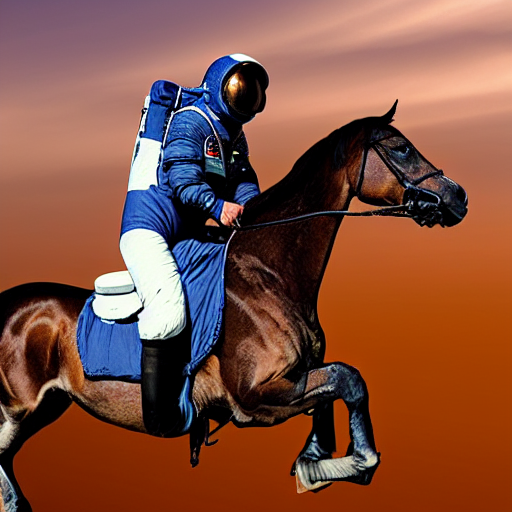

In [29]:
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

Now you have all the pieces to build your own pipelines or use diffusers components as you like 🔥.